In [19]:
import pandas as pd
import numpy as np

# Load the dataset
try:
    df = pd.read_csv('/content/food_order.csv')
    print("Data loaded successfully.")
    print(df.head())
except FileNotFoundError:
    print("Error: The file 'food_order.csv' was not found.")
    exit()

# --- Data Cleaning and Preprocessing ---

# 1. Clean 'rating' column: Replace 'Not given' with NaN
df['rating'] = df['rating'].replace('Not given', np.nan).astype(float)
# 2. Ensure numeric columns are correct types
numeric_cols = ['cost_of_the_order', 'food_preparation_time', 'delivery_time']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Handle missing values in cost/time by dropping them (small percentage)
df.dropna(subset=numeric_cols, inplace=True)

# 4. Feature Engineering: Calculate Total Order Time
df['total_order_time'] = df['food_preparation_time'] + df['delivery_time']



Data loaded successfully.
   order_id  customer_id            restaurant_name cuisine_type  \
0   1477147       337525                    Hangawi       Korean   
1   1477685       358141  Blue Ribbon Sushi Izakaya     Japanese   
2   1477070        66393                Cafe Habana      Mexican   
3   1477334       106968  Blue Ribbon Fried Chicken     American   
4   1478249        76942           Dirty Bird to Go     American   

   cost_of_the_order day_of_the_week     rating  food_preparation_time  \
0              30.75         Weekend  Not given                     25   
1              12.08         Weekend  Not given                     25   
2              12.23         Weekday          5                     23   
3              29.20         Weekend          3                     25   
4              11.59         Weekday          4                     25   

   delivery_time  
0             20  
1             23  
2             28  
3             15  
4             24  


In [10]:
# --- Key Performance Indicator (KPI) Benchmarks ---

print("--- Overall Business Performance Benchmarks ---")
print(f"Total Number of Orders: {len(df)}")
print(f"Mean Order Cost: ${df['cost_of_the_order'].mean():.2f}")
print(f"Mean Total Order Time: {df['total_order_time'].mean():.2f} minutes")
print(f"Overall Customer Rating (Mean of provided ratings): {df['rating'].mean():.2f} (N={df['rating'].notna().sum()})\n")

--- Overall Business Performance Benchmarks ---
Total Number of Orders: 1898
Mean Order Cost: $16.50
Mean Total Order Time: 51.53 minutes
Overall Customer Rating (Mean of provided ratings): 4.34 (N=1162)



In [14]:
# Group by cuisine type and calculate aggregated metrics
cuisine_analysis = df.groupby('cuisine_type').agg(
    order_count=('order_id', 'count'),
    mean_cost=('cost_of_the_order', 'mean'),
    mean_prep_time=('food_preparation_time', 'mean'),
    mean_delivery_time=('delivery_time', 'mean'),
    mean_total_time=('total_order_time', 'mean'),
    mean_rating=('rating', 'mean'),
    pct_rated=('rating', lambda x: x.notna().sum() / len(x)) # Percentage of orders that received a rating
)

# Sort by number of orders (demand)
cuisine_analysis.sort_values(by='order_count', ascending=False, inplace=True)

print("--- Analysis 1: Cuisine Performance and Demand ---")
# Apply formatting
cuisine_analysis['mean_cost'] = cuisine_analysis['mean_cost'].map('${:,.2f}'.format)
cuisine_analysis['mean_total_time'] = cuisine_analysis['mean_total_time'].map('{:.2f} min'.format)
cuisine_analysis['mean_rating'] = cuisine_analysis['mean_rating'].map('{:.2f}'.format)
cuisine_analysis['pct_rated'] = cuisine_analysis['pct_rated'].map('{:.1%}'.format)

print("Cuisine Type | Demand | Avg Cost | Avg Time | Avg Rating | % Rated")
print("-" * 75)
print(cuisine_analysis.to_string())


--- Analysis 1: Cuisine Performance and Demand ---
Cuisine Type | Demand | Avg Cost | Avg Time | Avg Rating | % Rated
---------------------------------------------------------------------------
                order_count mean_cost  mean_prep_time  mean_delivery_time mean_total_time mean_rating pct_rated
cuisine_type                                                                                                   
American                584    $16.32       27.440068           24.193493       51.63 min        4.30     63.0%
Japanese                470    $16.30       27.510638           24.131915       51.64 min        4.37     58.1%
Italian                 298    $16.42       27.483221           24.567114       52.05 min        4.36     57.7%
Chinese                 215    $16.31       27.511628           23.855814       51.37 min        4.34     61.9%
Mexican                  77    $16.93       26.727273           24.389610       51.12 min        4.42     62.3%
Indian                

In [13]:
# --- Analysis 2: Day of the Week Performance Comparison ---

# Group by day of the week
day_analysis = df.groupby('day_of_the_week').agg(
    order_count=('order_id', 'count'),
    mean_cost=('cost_of_the_order', 'mean'),
    mean_total_time=('total_order_time', 'mean'),
    mean_rating=('rating', 'mean'),
)

day_analysis.sort_values(by='order_count', ascending=False, inplace=True)

print("--- Analysis 2: Day of the Week Demand and Efficiency ---")
day_analysis_formatted = day_analysis.copy()
day_analysis_formatted['mean_cost'] = day_analysis_formatted['mean_cost'].map('${:,.2f}'.format)
day_analysis_formatted['mean_total_time'] = day_analysis_formatted['mean_total_time'].map('{:.2f} min'.format)
day_analysis_formatted['mean_rating'] = day_analysis_formatted['mean_rating'].map('{:.2f}'.format)

print("Day | Demand | Avg Cost | Avg Time | Avg Rating")
print("-" * 55)
print(day_analysis_formatted.to_string())


--- Analysis 2: Day of the Week Demand and Efficiency ---
Day | Demand | Avg Cost | Avg Time | Avg Rating
-------------------------------------------------------
                 order_count mean_cost mean_total_time mean_rating
day_of_the_week                                                   
Weekend                 1351    $16.57       49.91 min        4.36
Weekday                  547    $16.31       55.55 min        4.31


In [18]:
# --- Analysis 3: Segmentation of High-Value Orders ---

# Define a high-value order of 25%
cost_threshold = df['cost_of_the_order'].quantile(0.75)
high_value_df = df[df['cost_of_the_order'] >= cost_threshold]

print(f"--- Analysis 3: High-Value Order Segmentation (Cost >= ${cost_threshold:.2f}) ---")

# Analyze which cuisines drive the highest value
high_value_cuisine = high_value_df.groupby('cuisine_type').agg(
    high_value_order_count=('order_id', 'count'),
    mean_rating=('rating', 'mean')
).sort_values(by='high_value_order_count', ascending=False)
comparison = pd.merge(
    high_value_cuisine[['high_value_order_count', 'mean_rating']],
    cuisine_analysis[['order_count', 'mean_rating']].rename(columns={'mean_rating': 'overall_mean_rating'}),
    left_index=True,
    right_index=True
)

# Apply formatting for better readability
comparison['high_value_mean_rating'] = comparison['mean_rating'].map('{:.2f}'.format)
comparison['overall_mean_rating'] = comparison['overall_mean_rating']#.map('{:.2f}'.format) # Remove redundant formatting
comparison['high_value_pct_total'] = (comparison['high_value_order_count'] / comparison['order_count']).map('{:.1%}'.format)

print(f"\nCuisines Driving High-Value Orders (Cost > ${cost_threshold:.2f}):")
print("High-Value Count | High-Value Avg Rating | Overall Avg Rating | % of Cuisine's Orders (High-Value)")
print("-" * 100)
print(comparison[['high_value_order_count', 'high_value_mean_rating', 'overall_mean_rating', 'high_value_pct_total']].to_string())

--- Analysis 3: High-Value Order Segmentation (Cost >= $22.30) ---

Cuisines Driving High-Value Orders (Cost > $22.30):
High-Value Count | High-Value Avg Rating | Overall Avg Rating | % of Cuisine's Orders (High-Value)
----------------------------------------------------------------------------------------------------
                high_value_order_count high_value_mean_rating overall_mean_rating high_value_pct_total
cuisine_type                                                                                          
American                           143                   4.36                4.30                24.5%
Japanese                           111                   4.34                4.37                23.6%
Italian                             73                   4.45                4.36                24.5%
Chinese                             52                   4.37                4.34                24.2%
Mexican                             21                   4.36 

/tmp/ipython-input-386392849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=comparison.index, y='high_value_pct_total_numeric', data=comparison, palette='viridis')


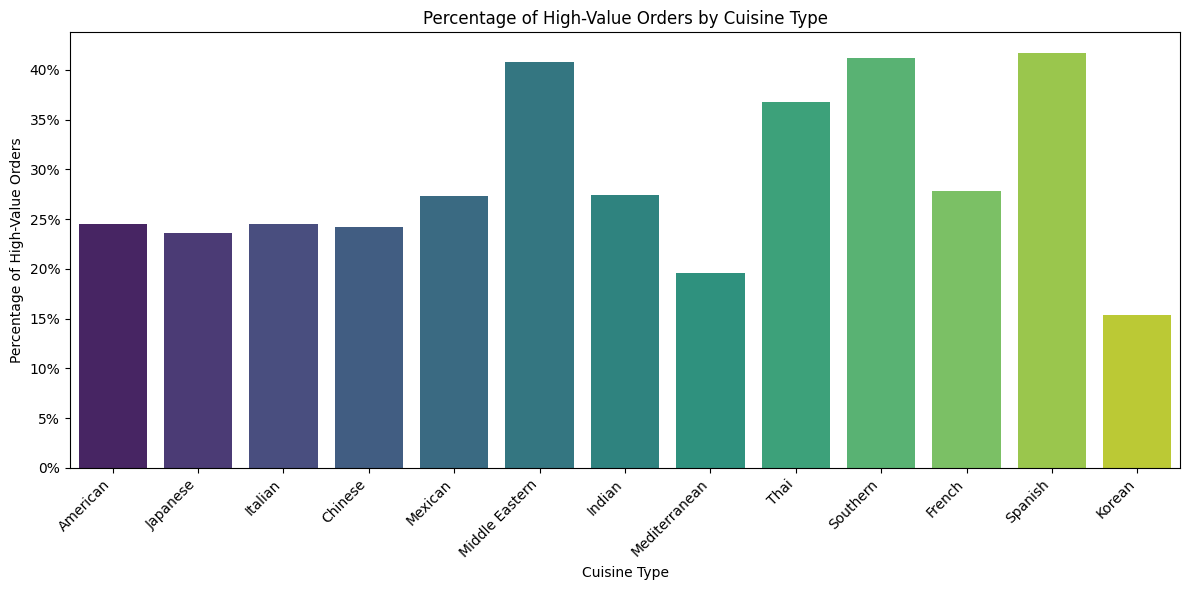

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the percentage column is numeric for plotting
comparison['high_value_pct_total_numeric'] = comparison['high_value_pct_total'].str.rstrip('%').astype('float') / 100.0

plt.figure(figsize=(12, 6))
sns.barplot(x=comparison.index, y='high_value_pct_total_numeric', data=comparison, palette='viridis')
plt.title('Percentage of High-Value Orders by Cuisine Type')
plt.xlabel('Cuisine Type')
plt.ylabel('Percentage of High-Value Orders')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()